## Surface topography kernels

Follows the approach of Parsons & Daly (1983) and Robinson & Parsons (1987) to compute spectral/depth response functions for the surface topography in a buoyancy driven Stokes flow. 



  0. Parsons, B., and S. Daly (1983), The relationship between surface topography, gravity anomalies, and temperature structure of convection, Journal of Geophysical Research: Solid Earth (1978–2012), 88(B2), 1129–1144, doi:10.1029/JB088iB02p01129.

  0.  Robinson, E. M., B. Parsons, and S. F. Daly (1987), The effect of a shallow low viscosity zone on the apparent compensation of mid-plate swells, Earth and Planetary Science Letters, 82(3-4), 335–348, doi:10.1016/0012-821X(87)90207-X.


In [1]:
## Kernels     

%matplotlib inline

import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt

In [2]:
dim = 2
meshX = 64
meshY = 64

Q1dP0Mesh = uw.mesh.FeMesh_Cartesian( elementType='Q1/dQ0',
                                      elementRes=(meshX,meshY), 
                                      minCoord=(0.,0.), maxCoord=(1.,1.)  )

Q1Mesh =  Q1dP0Mesh # returns outer mesh by default
dP0Mesh = Q1dP0Mesh.subMesh

velocityMesh =  Q1Mesh
pressureMesh = dP0Mesh

xCoordFn = fn.input()[0]
yCoordFn = fn.input()[1]

x_coordinates = xCoordFn.evaluate(velocityMesh.specialSets["MinJ_VertexSet"])
y_coordinates = yCoordFn.evaluate(velocityMesh.specialSets["MinI_VertexSet"])



In [3]:
# create & zero meshvariables
velocityField    = uw.mesh.MeshVariable( mesh=velocityMesh,   nodeDofCount=dim )
pressureField    = uw.mesh.MeshVariable( mesh=pressureMesh,   nodeDofCount=1 )
temperatureField = uw.mesh.MeshVariable( mesh=velocityMesh,   nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.

In [4]:
IWalls = velocityMesh.specialSets["MinI_VertexSet"] + velocityMesh.specialSets["MaxI_VertexSet"]
JWalls = velocityMesh.specialSets["MinJ_VertexSet"] + velocityMesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition(    variable=velocityField, 
                                                  indexSetsPerDof=(IWalls,JWalls) )

# temperature does not evolve with time so no bcs are needed

In [5]:
# UW function to define a layered viscosity

layer1Viscosity = fn.misc.constant(100.0)
layer2Viscosity = fn.misc.constant(0.1)
layer3Viscosity = fn.misc.constant(1.0)

layer1Depth = 0.9
layer2Depth = 0.7
layer3Depth = 0.0

xCoordFn = fn.input()[0]
yCoordFn = fn.input()[1]

fn_viscosity = fn.branching.conditional(
    [ ( yCoordFn > layer1Depth , layer1Viscosity ),
      ( yCoordFn > layer2Depth , layer2Viscosity ), 
      (                   True , layer3Viscosity )  ] )

# UW function to compute the total stress and vertical stress at any given point
# And a filter function to grab the coordinates at the node points



In [6]:
# Setup a stokes system
# For PIC style integration, we include a swarm for the a PIC integration swarm is generated within.
# For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.

forceFn = (0.0, 1.0) * temperatureField

stokesEqn = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=fn.exception.SafeMaths(fn_viscosity), 
                              fn_bodyforce=forceFn )

solver=uw.systems.Solver(stokesEqn)

solver.options.main.Q22_pc_type='uwscale'  # also try 'gtkg', 'gkgdiag' and 'uwscale'
solver.options.main.penalty = 1.0
solver.options.A11.ksp_rtol=1e-6
solver.options.scr.ksp_rtol=1e-5
solver.options.scr.use_previous_guess = True
solver.options.scr.ksp_set_min_it_converge = 1
solver.options.scr.ksp_set_max_it = 100
solver.options.mg.levels = 5
solver.options.mg.mg_levels_ksp_type = 'chebyshev'
solver.options.mg_accel.mg_accelerating_smoothing = True
solver.options.mg_accel.mg_accelerating_smoothing_view = False
solver.options.mg_accel.mg_smooths_to_start = 1

# Load this solver onto the equation system (displacing the default)
stokesEqn.solve = solver.solve

stresstensorFn =  2.* stokesEqn.fn_viscosity*fn.tensor.symmetric( velocityField.gradientFn ) - pressureField
verticalStressFn = stresstensorFn[1]



In [7]:
# a function to calculate the response for a depth / wavenumber combo

def single_layer_temperature(wavenumber, layer_height):
    """
    Place a harmonic 'delta function' at a given layer in the mesh.   
    Assumes global: temperatureField, velocityMesh, meshX, meshY
    """

    import numpy as numpy

    k = wavenumber * math.pi

    T = temperatureField.data.reshape(meshY+1,meshX+1)
    X = velocityMesh.data.reshape(meshY+1,meshX+1,2)

    T[...] = 0.0
    T[layer_height,:] = numpy.cos( k * X[layer_height,:,0] )

    return T.reshape((meshX+1)*(meshY+1),1)

def layer_fft(data):
    """
    Find fft of data in 1d - this is intended to be a mesh layer - so if the mesh is not uniform
    it will do something about it !
    """

    from scipy import fftpack as fft
    import numpy as np
    
    samples = len(data)
#     packed_data = np.empty(2*samples-1)
#     packed_data[0:samples] = data[:]
#     packed_data[samples:2*samples] = data[samples:0:-1]

    dataFT = fft.dct(data) / samples
    
    return dataFT



def direct_wavenumber_topo_kernel(wavenumber):
    """
    Compute the response at a given wavenumber for each layer at depth and return kernel for the same wavenumber
    Assumes global: temperatureField, velocityMesh, meshX, meshY, 
    """

    import numpy as np

    kernel = np.empty(meshY+1)

    kernel[0] = 0
    kernel[-1] = 1.0
    
    for layer in range(2,meshY-1,2):
        
        temperatureField.data[:] = meshY * single_layer_temperature(wavenumber, layer)
        stokesEqn.solve()   
        surface_topography = -verticalStressFn.evaluate(velocityMesh.specialSets["MaxJ_VertexSet"]).T[0]

        kfft = layer_fft(surface_topography)
        kernel[layer] = layer_fft(surface_topography)[wavenumber]
        
    for layer in range(1,meshY,2):
        kernel[layer] = 0.5 * (kernel[layer-1] + kernel[layer+1])
        
    return kernel
 
    
def all_wavenumber_topo_kernel(wavenumber):
    """
    Compute the response at a given wavenumber for each layer at depth and return kernel for the same wavenumber
    Assumes global: temperatureField, velocityMesh, meshX, meshY, 
    """

    import numpy as np

    kernels = np.empty((meshY+1,meshX+1))

    kernels[0][:] = 0
    kernels[-1][:] = 0
    kernels[-1][wavenumber] = 1.0
    
    for layer in range(2,meshY-1,2):
        
        temperatureField.data[:] = meshY * single_layer_temperature(wavenumber, layer)
        stokesEqn.solve()   
        surface_topography = -verticalStressFn.evaluate(velocityMesh.specialSets["MaxJ_VertexSet"]).T[0]

        kernels[:][layer] = layer_fft(surface_topography)
        
    for layer in range(1,meshY,2):
        kernels[layer][:] = 0.5 * (kernels[layer-1][:] + kernels[layer+1][:])
        
    return kernels


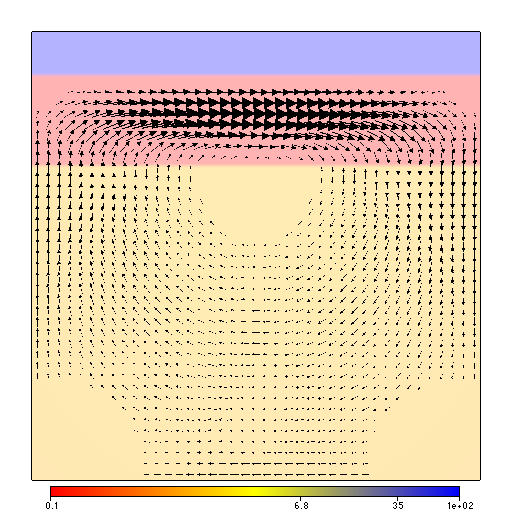

In [8]:
# Test this by hand with a single layer driving buoyancy
temperatureField.data[:] = meshY * single_layer_temperature(1.0, 50)
solver.solve()
vscale = velocityField.evaluate(velocityMesh).max()

figtemp = plt.Figure(figsize=(512,512))
figtemp.VectorArrows(velocityField, velocityMesh, lengthScale=0.1/vscale, resolutionX=41, resolutionY=41)
figtemp.Surface(fn_viscosity, velocityMesh, colours=["red", "yellow", "blue"], colourBar=True, logScale=True, opacity=0.3)
figtemp.show()

(-0.05, 1.05)

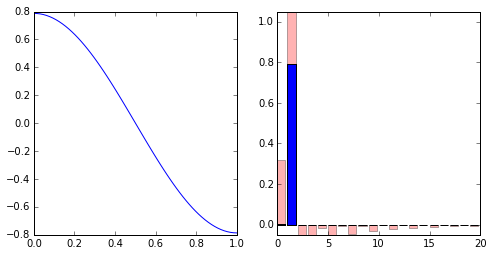

In [9]:
## Compute (total) stress, and thus topography and see how that looks in real / fourier domain

surface_topography = -verticalStressFn.evaluate(velocityMesh.specialSets["MaxJ_VertexSet"]).T[0]
x_coordinates = xCoordFn.evaluate(velocityMesh.specialSets["MaxJ_VertexSet"])
y_coordinates = yCoordFn.evaluate(velocityMesh.specialSets["MinI_VertexSet"])

import matplotlib.pyplot as pyplot

fig, (plot1,plot2) = pyplot.subplots(1,2)
fig.set_alpha=0.5
fig.set_size_inches(8,4)

plot1.plot(x_coordinates, surface_topography)

surface_topography_fft = layer_fft(surface_topography)

plot2.bar(range(0,len(surface_topography_fft)), surface_topography_fft*100, color="red", alpha=0.3, width=0.8)
plot2.bar(range(0,len(surface_topography_fft)), surface_topography_fft)

plot2.set_xlim(0,20)
plot2.set_ylim(-0.05,1.05)

In [10]:
kernel2 = direct_wavenumber_topo_kernel(2)

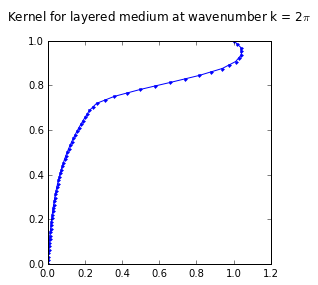

In [11]:
import matplotlib.pyplot as pyplot
import numpy as np

fig, (plot1) = pyplot.subplots(1,1)
fig.set_alpha=0.5
fig.set_size_inches(4,4)
plot1.plot(kernel2, y_coordinates, marker='.')
plot1.set_ylim(0.0,1.0)
plot1.set_title("Kernel for layered medium at wavenumber k = 2$\pi$ \n")

# np.savez("ThreeLayer_100_01_1_Kernel2", kernel=kernel2, y=y_coordinates)

## Mode coupling and solver tolerances

We don't need the analytic solutions to test for erroneous mode coupling in layered viscosity cases. There should be no signal at wavelengths not represented in the driving buoyancy.

The high wavenumber modes from low-wavenumber driving buoyancy terms and the low wavenumber modes for high-wavenumber buoyancy terms seem to be diagnostic here. Though it's not obvious what this actually means.

In [12]:
# Can we use this result to estimate required tolerances ?

solver.options.A11.ksp_rtol=1e-7
solver.options.scr.ksp_rtol=1e-6

kernels2 = all_wavenumber_topo_kernel(2)
kernels5 = all_wavenumber_topo_kernel(5)

solver.options.A11.ksp_rtol=1e-4
solver.options.scr.ksp_rtol=1e-3

kernels2_lr = all_wavenumber_topo_kernel(2)
kernels5_lr = all_wavenumber_topo_kernel(5)


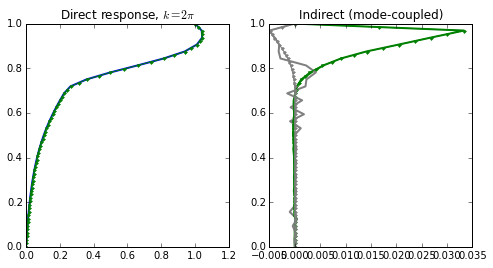

In [13]:
import matplotlib.pyplot as pyplot

fig, (plot1, plot2) = pyplot.subplots(1,2)
fig.set_alpha=0.5
fig.set_size_inches(8,4)

plot1.plot(kernels2[:,2], y_coordinates, marker='', linewidth=2.0)
plot1.plot(kernels2_lr[:,2], y_coordinates, marker='.', linewidth=1.0)
plot1.set_ylim(0.0,1.0)
plot1.set_title("Direct response, $k=2\pi$")

plot2.plot(kernels2_lr[:,1], y_coordinates, marker='', color='green', linewidth=2)
plot2.plot(kernels2_lr[:,5], y_coordinates, marker='', color='gray', linewidth=2)
plot2.plot(kernels2[:,1], y_coordinates, marker='.', color='green', linewidth=1)
plot2.plot(kernels2[:,5], y_coordinates, marker='.', color='gray', linewidth=1)
plot2.set_ylim(0.0,1.0)
plot2.set_title("Indirect (mode-coupled)")


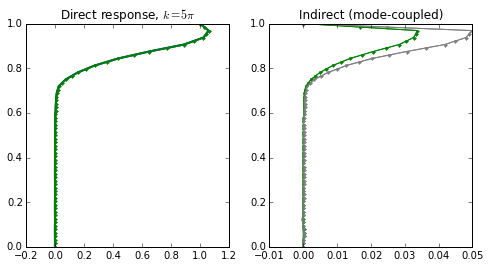

In [14]:
import matplotlib.pyplot as pyplot

fig, (plot1, plot2) = pyplot.subplots(1,2)
fig.set_size_inches(8,4)

plot1.plot(kernels5[:,5], y_coordinates, marker='', linewidth=2.0)
plot1.plot(kernels5_lr[:,5], y_coordinates, marker='.', linewidth=2.0)
plot1.set_ylim(0.0,1.0)
plot1.set_title("Direct response, $k=5\pi$")

plot2.plot(kernels5_lr[:,1], y_coordinates, marker='.', color='green', linewidth=1)
plot2.plot(kernels5_lr[:,3], y_coordinates, marker='.', color='gray', linewidth=1)
plot2.plot(kernels5[:,1], y_coordinates, marker='', color='green', linewidth=1)
plot2.plot(kernels5[:,3], y_coordinates, marker='', color='gray', linewidth=1)
plot2.set_ylim(0.0,1.0)
plot2.set_title("Indirect (mode-coupled)")


# Compare with analytic solutions for laterally varying viscosity

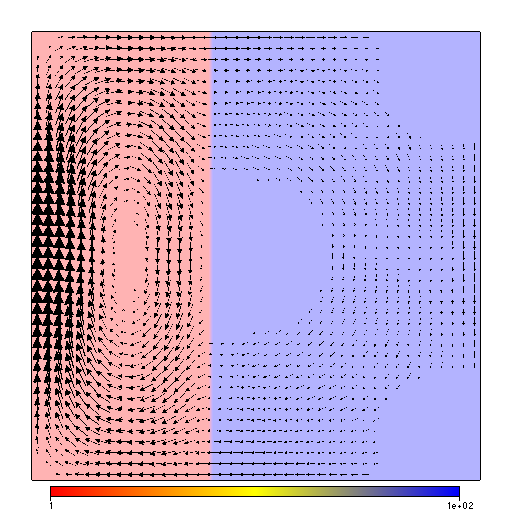

In [15]:
# First the harmonic force function from SolA

solA = fn.analytic.SolCx(viscosityA=1.0, viscosityB=100.0, xc=0.4, nx=1)
stokesEqn.fn_viscosity = solA.fn_viscosity
stokesEqn.fn_bodyforce = solA.fn_bodyforce
stresstensorFn =  2.0 * stokesEqn.fn_viscosity*fn.tensor.symmetric( velocityField.gradientFn ) - pressureField
anal_stresstensorFn =  fn.tensor.deviatoric(solA.stressFn) - solA.pressureFn

verticalStressFn = stresstensorFn[1] 
anal_verticalStressFn = anal_stresstensorFn[1]

# Check it ... 

solver.options.A11.ksp_rtol=1e-7
solver.options.scr.ksp_rtol=1e-6

# temperatureField.data[:] = meshY * single_layer_temperature(1.0, 50)

stokesEqn.solve()
vscale = velocityField.evaluate(velocityMesh).max()

figSolAVisc = plt.Figure(figsize=(512,512))
figSolAVisc.Surface(stokesEqn.fn_viscosity, velocityMesh, colours=["red", "yellow", "blue"], colourBar=True, logScale=False, opacity=0.3)
figSolAVisc.VectorArrows(velocityField, velocityMesh, lengthScale=0.1/vscale, resolutionX=41, resolutionY=41)
figSolAVisc.show()

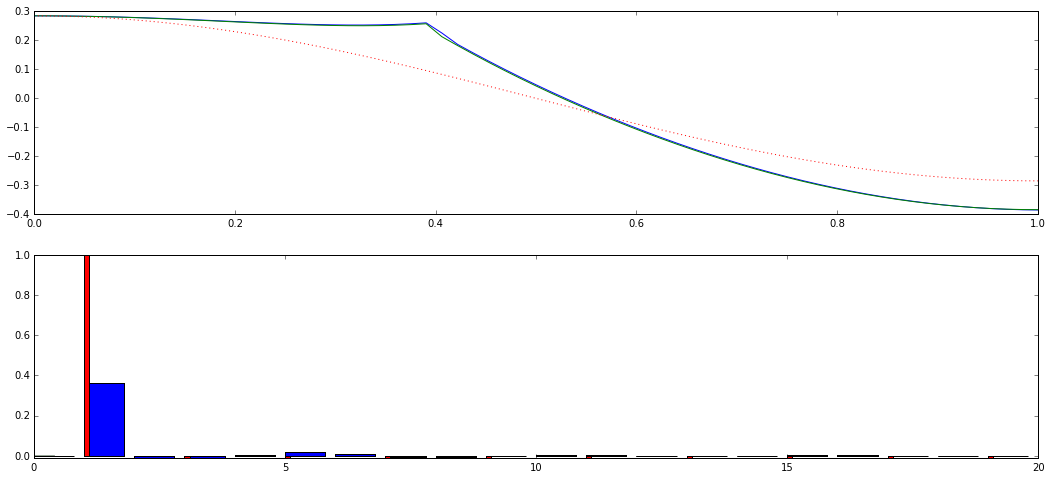

In [16]:
## Compute (total) stress, and thus topography and see how that looks in real / fourier domain
## A cosine is added to demonstrate the performance of layer fft in an ideal case 

surface_topography = -verticalStressFn.evaluate(velocityMesh.specialSets["MaxJ_VertexSet"]).T[0]
anal_surface_topography = -anal_verticalStressFn.evaluate(velocityMesh.specialSets["MaxJ_VertexSet"]).T[0]


import matplotlib.pyplot as pyplot

fig, (plot1,plot2) = pyplot.subplots(2,1)
fig.set_alpha=0.5
fig.set_size_inches(18,8)

plot1.plot(x_coordinates, surface_topography)
plot1.plot(x_coordinates, anal_surface_topography)
plot1.plot(x_coordinates, np.cos(x_coordinates.T[0]*math.pi) * surface_topography.max(), linestyle=":")

surface_topography_fft = layer_fft(surface_topography)
anal_surface_topography_fft = layer_fft(anal_surface_topography)
test_surface_topography_fft = layer_fft(np.cos(x_coordinates.T[0]*math.pi) * surface_topography.max())

#plot2.bar(range(0,len(surface_topography_fft)), surface_topography_fft*100, color="red", alpha=0.3, width=0.8)
plot2.bar(range(0,len(surface_topography_fft)), surface_topography_fft, color="green", alpha=0.3, width=0.4)
plot2.bar(range(0,len(surface_topography_fft)), anal_surface_topography_fft)
plot2.bar(range(0,len(surface_topography_fft)), 1.0e8*test_surface_topography_fft, color="red", width=0.1)


plot2.set_xlim(0,20)
plot2.set_ylim(-0.01,1.0)
pass


In [17]:
solver.options.A11.ksp_rtol=1e-7
solver.options.scr.ksp_rtol=1e-6
stokesEqn.fn_bodyforce = forceFn

kernels1a = all_wavenumber_topo_kernel(1)
kernels5a = all_wavenumber_topo_kernel(5)

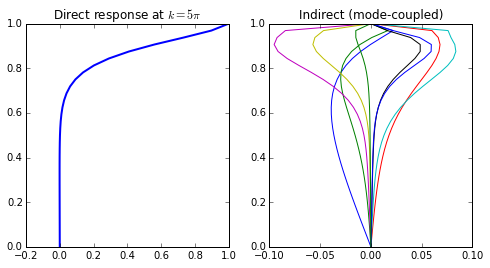

In [18]:
import matplotlib.pyplot as pyplot

k_array = kernels5a
kd = 5
ki_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
try:
    ki_list.remove(kd)
except:
    pass

fig, (plot1, plot2) = pyplot.subplots(1,2)
fig.set_alpha=0.5
fig.set_size_inches(8,4)

plot1.plot(k_array[:,kd], y_coordinates, marker='', linewidth=2.0)
plot1.set_ylim(0.0,1.0)
plot1.set_title("Direct response at $k={:d}\pi$".format(kd))

for k in ki_list:
    plot2.plot(k_array[:,k], y_coordinates, marker='', linewidth=1)
    
plot2.set_ylim(0.0,1.0)
plot2.set_title("Indirect (mode-coupled)")